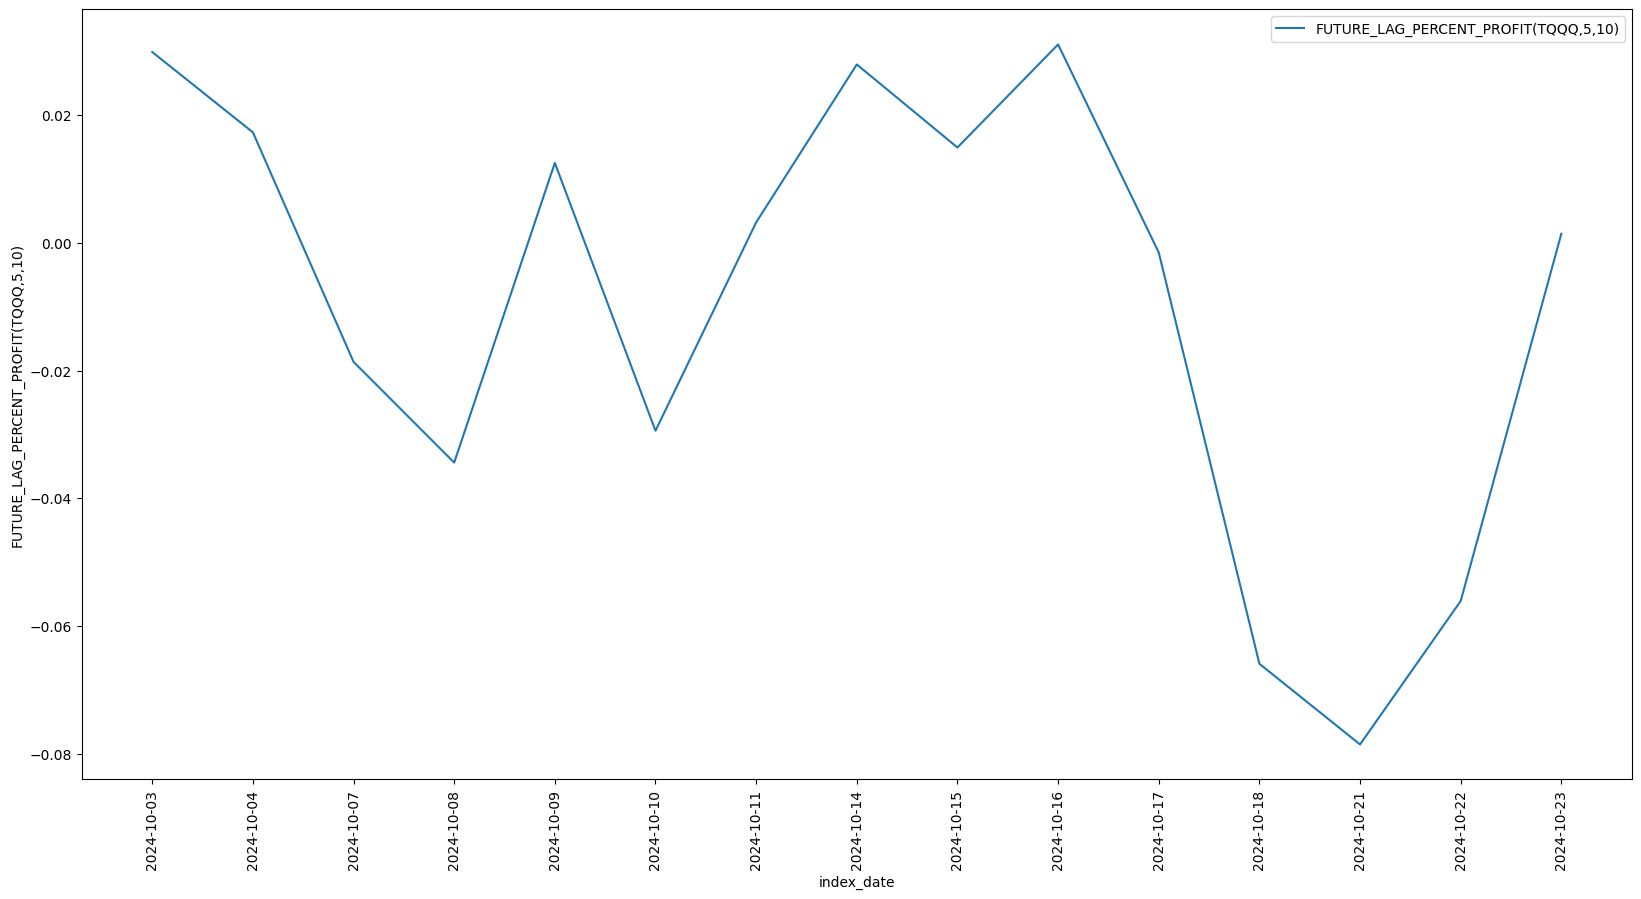

0.7057761732851986
STOCH_OSC_RAVG(IDXBUK100P,34,13)|STOCH_OSC(IDXAXJO,89)|RATIO_TO_RLINEAR(C(AGGDOG),13)|QUANTILE_RATIO(C(AGGDOG),5,0.10,0.90)|QUANTILE_RATIO(C(AGGDOG),3,0.10,0.90)|QUANTILE_RATIO(C(DTP3HA32),34,0.10,0.90)|RAVGS_RATIO(C(IDXGSPC),89,21)|RKURT(C(RIFSPPNAAD01NB),34)|RSI(V(IDXDJI),55)|RENTROPY(H(GBPJPYX),5)|STOCH_OSC(IDXIXIC,233)|QUANTILE_RATIO(C(DGS30),89,0.25,0.75)|RATIO_TO_RLINEAR(C(AGGDOL),13)|RATIO_TO_RAVG(H(CNYX),55)|QUANTILE_RATIO(C(RPAGYD),3,0.10,0.90)|RAVGS_RATIO(O(SLV),3,21)|RATIO_TO_RAVG(H(IAU),233)|RSI(L(CNYX),3)|STOCH_OSC_RAVG(MXNX,5,5)|MACDSLOW(C(BAMLEM3BRRBBCRPISYTW))
0.6964285714285714
STOCH_OSC_RAVG(IDXBUK100P,34,13)|STOCH_OSC(SPXL,55)|RATIO_TO_RLINEAR(C(AGGDOG),13)|QUANTILE_RATIO(C(AGGDOG),5,0.10,0.90)|QUANTILE_RATIO(C(AGGDOG),3,0.10,0.90)|QUANTILE_RATIO(C(DTP3HA32),34,0.10,0.90)|RAVGS_RATIO(C(IDXGSPC),89,21)|RKURT(C(RIFSPPNAAD01NB),34)|RSI(V(IDXDJI),55)|RENTROPY(H(GBPJPYX),5)|STOCH_OSC(IDXIXIC,233)|QUANTILE_RATIO(C(DGS30),89,0.25,0.75)|RATIO_TO_RLINEAR(C(

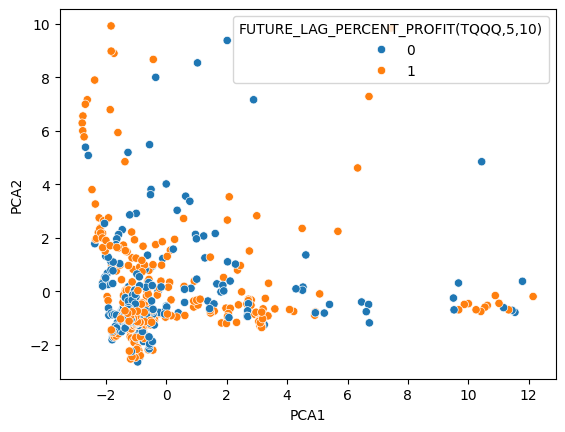

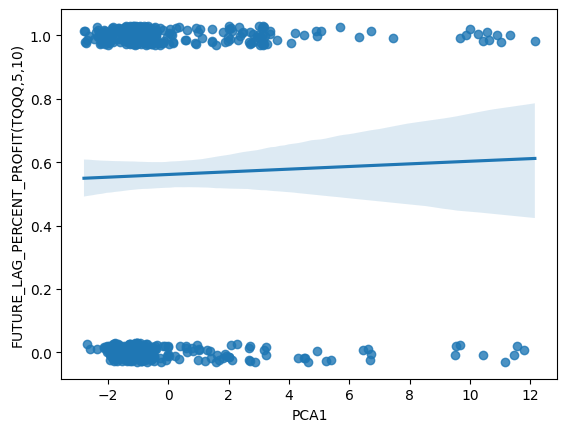

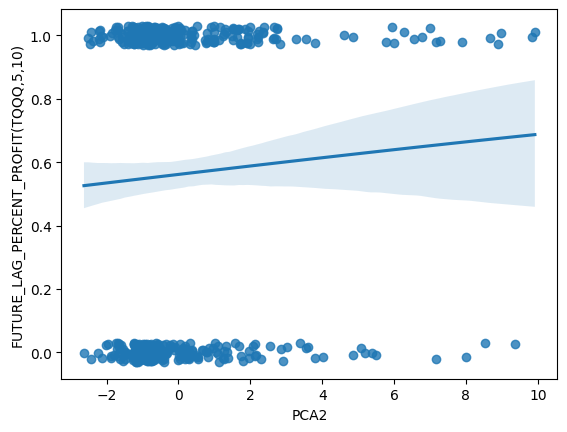

0.7057761732851986

In [3]:
import random

from pynoahdb.symbolseries import SymbolSeries
from pynoahfunc.processor import Processor
from pywortutil.algos import Genetic

#suppress warnings
import warnings
warnings.filterwarnings("ignore")


PARAM1_WINDOW_SIZES = [3,5,8,13,21,34,55,89,144,233]
PARAM2_WINDOW_SIZES = [5,8,13,21,34,55,89,144,233,377]

PARAM1_RATIO = [0.10,0.25,0.5,0.75,0.90]

OUTER_VARS = ["C({0})","H({0})","L({0})","O({0})","V({0})"]

FUNCTIONS = [
    ["RATIO_TO_RAVG({0},{1})",["t","w"],False],
    ["RATIO_TO_RLINEAR({0},{1})",["t","w"],False],
    ["QUANTILE_RATIO({0},{1},0.25,0.75)",["t","w"],False],
    ["QUANTILE_RATIO({0},{1},0.10,0.90)",["t","w"],False],
    ["MACDFAST({0})",["t"],False],
    ["MACDSLOW({0})",["t"],False],
    ["RSI({0},{1})",["t","w"],False],
    ["STOCH_OSC({0},{1})",["s","w"],True],
    ["RENTROPY({0},{1})",["t","w"],False],
    ["RKURT({0},{1})",["t","w"],False],
    ["RSKEW({0},{1})",["t","w"],False],
    ["RAVG_MEDIAN({0},{1})",["t","w"],False],
    ["RAVGS_RATIO({0},{1},{2})",["t","w","w"],False],
    ["RSEMS_RATIO({0},{1},{2})",["t","w","w"],False],
    ["STOCH_OSC_RAVG({0},{1},{2})",["s","w","w"],True],
    ["W_VOL_AVG({0},{1},{2})",["s","w","w"],True],
]

SYMBOL_TYPES = ["EQUITY","INDEX","ETF","CURRENCY","FRED","AGGREGATE"]

EQUITY_SYMBOLS = SymbolSeries().symbol_list("EQUITY")
INDEX_SYMBOLS = SymbolSeries().symbol_list("INDEX")
ETF_SYMBOLS = SymbolSeries().symbol_list("ETF")
CURRENCY_SYMBOLS = SymbolSeries().symbol_list("CURRENCY")
FRED_SYMBOLS = SymbolSeries().symbol_list("FRED")
AGGREGATE_SYMBOLS = SymbolSeries().symbol_list("AGGREGATE")

def generate_functions(f_count):
    #Get the symbols
    symbols = SymbolSeries().symbol_list()

    ret_list = []

    selected_functions = 0

    while selected_functions < f_count:
        #Get the function
        function = random.choice(FUNCTIONS)

        sym_type = random.choice(SYMBOL_TYPES)

        #Get the symbol
        if sym_type == "EQUITY":
            symbol = random.choice(EQUITY_SYMBOLS)
        elif sym_type == "INDEX":
            symbol = random.choice(INDEX_SYMBOLS)
        elif sym_type == "ETF":
            symbol = random.choice(ETF_SYMBOLS)
        elif sym_type == "CURRENCY":
            symbol = random.choice(CURRENCY_SYMBOLS)
        elif sym_type == "FRED":
            symbol = random.choice(FRED_SYMBOLS)
        elif sym_type == "AGGREGATE":
            symbol = random.choice(AGGREGATE_SYMBOLS)

        ##if the function requires a symbol and the symbol has only close data
        if function[2] and symbol[1]:
            continue #skip this iteration

        #Get the parameters
        params = []
        for p in function[1]:
            if p == "s":
                params.append(symbol[0])
            elif p == "w":
                params.append(random.choice(PARAM1_WINDOW_SIZES))
            elif p == "t":
                if symbol[1]:
                    params.append(f"C({symbol[0]})")
                else:
                    metric = random.choice(OUTER_VARS)
                    params.append(metric.format(symbol[0]))

        try:
            ret_list.append(Processor().process(function[0].format(*params), autoscale = True, scale_type = "robust"))
            selected_functions += 1
        except:
            continue

    return ret_list

def evaluate_functions(df_X_arr, show_metrics = False):
    try:
        df = df_X_arr[0]
        for i in range(1,len(df_X_arr)):
            df = pd.merge(df, df_X_arr[i], on='index_date', how='inner')

        #Merge the dataframes
        df = pd.merge(df, DF_TARGET, on='index_date', how='inner')

        df.dropna(inplace=True)

        #if we have less than 1000 rows, skip
        if df.shape[0] < 500:
            return -1.0
        
        Y = df[target_func]
        X = df.drop(columns=[target_func])

        Y_pos = Y[Y == 1].count()
        Y_neg = Y[Y == 0].count()

        #Compute regression weights
        weights = {0:Y_pos/(Y_pos+Y_neg), 1:Y_neg/(Y_pos+Y_neg)}

        model = LogisticRegression(class_weight=weights)
        model.fit(X, Y)
        score = model.score(X,Y)
        
        if show_metrics:
            Y_pred = model.predict(X)
            print("Confusion matrix: ")
            print(metrics.confusion_matrix(Y,Y_pred))
            print("Classification report: ")
            print(metrics.classification_report(Y,Y_pred))

            PCA_model = PCA(n_components=4)
            X = PCA_model.fit_transform(X)

            if show_metrics:
                print("Explained variance: ",PCA_model.explained_variance_ratio_)
                print("Sum of explained variance: ",sum(PCA_model.explained_variance_ratio_))

            #plot the 2d PCA
            df_pca = pd.DataFrame(X, columns = ["PCA1","PCA2", "PCA3", "PCA4"])

            #set the index column on df_pca
            df_pca.index = Y.index

            sns.scatterplot(data=df_pca, x="PCA1", y="PCA2", hue=Y)
            plt.show()

            sns.regplot(x=df_pca["PCA1"], y=Y, logistic=True, y_jitter=0.03)
            plt.show()
            sns.regplot(x=df_pca["PCA2"], y=Y, logistic=True, y_jitter=0.03)
            plt.show()


        
        return score
        
    except Exception as e:
        print(e)
        # raise e
        return -1.0
    
def gene_hash(gene):
    gen_hash = ""
    for g in gene:
        gen_hash += g.columns[0]
        
    return gen_hash


import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf 

#import logistic regression models
from sklearn.linear_model import LogisticRegression

import sklearn.metrics as metrics


import pandas as pd
import numpy as np

from sklearn.decomposition import PCA

target_func = "FUTURE_LAG_PERCENT_PROFIT(TQQQ,5,10)"

DF_TARGET = Processor().process(target_func)

plt.figure(figsize=(20,10))
sns.lineplot(data=DF_TARGET[-20:], x="index_date", y=target_func)
plt.xticks(rotation=90)
#show legend
plt.legend(["FUTURE_LAG_PERCENT_PROFIT(TQQQ,5,10)"])

plt.show()

DF_TARGET[target_func] = DF_TARGET[target_func].apply(lambda x: 1 if x > 0 else 0)

FUNCTION_COUNT = 20



algo = Genetic(generate_functions, evaluate_functions, gene_hash, cull_rate = 0.4, dominant_rate = 0.5, mutation_rate = 0.05, genetic_size = 20)

population = algo.run(20, initial_population = 500, stable_population_size = 20)

#sort the population by the fitness
population.sort(key=lambda x: x[1], reverse=True)

#print the columns of the best 10 items and the score
for i in range(10):
    print(population[i][1])
    functions = population[i][0]
    flist = []
    for f in functions:
        flist.append(f.columns[0])
    print("|".join(flist))

#show the metrics
evaluate_functions(population[0][0], show_metrics = True)